In [1]:
# Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyarrow

We are still working with the month of January 2021 for the power dataset

In [2]:
path_P = "../21-01/year_month=21-01/plugin=ipmi_pub/metric=total_power/a_0.parquet"
dataset_P = pd.read_parquet(path_P, engine='pyarrow')

# Casting of node values into integers
dataset_P['node'] = dataset_P['node'].astype(int)

# I want to extract from the whole dataset only the rows related to the node 0
dataset_P_node0 = dataset_P[dataset_P['node'] == 0]
del(dataset_P)
print(dataset_P_node0)

                          timestamp  value  node
211842    2021-01-20 23:36:20+00:00    440     0
211843    2021-01-20 23:36:40+00:00    420     0
211844    2021-01-20 23:37:00+00:00    440     0
211845    2021-01-20 23:37:20+00:00    440     0
211846    2021-01-20 23:37:40+00:00    440     0
...                             ...    ...   ...
112158837 2021-01-31 22:04:00+00:00    440     0
112158838 2021-01-31 22:04:20+00:00    440     0
112158839 2021-01-31 22:04:40+00:00    440     0
112158840 2021-01-31 22:05:00+00:00    440     0
112158841 2021-01-31 22:05:20+00:00    440     0

[114586 rows x 3 columns]


In [3]:
# As usual I need to order by datetime the samples I have
dataset_P_node0['timestamp'] = pd.to_datetime(dataset_P_node0['timestamp'])

dataset_P_node0 = dataset_P_node0.sort_values(by='timestamp')

print(dataset_P_node0)

                         timestamp  value  node
55240462 2021-01-01 00:00:00+00:00    380     0
55240463 2021-01-01 00:00:20+00:00    360     0
55240464 2021-01-01 00:00:40+00:00    360     0
55240465 2021-01-01 00:01:00+00:00    360     0
55240466 2021-01-01 00:01:20+00:00    360     0
...                            ...    ...   ...
69375705 2021-01-31 23:30:00+00:00    440     0
69375706 2021-01-31 23:30:20+00:00    420     0
69375707 2021-01-31 23:30:40+00:00    440     0
69375708 2021-01-31 23:31:00+00:00    420     0
69375709 2021-01-31 23:43:40+00:00    440     0

[114586 rows x 3 columns]


In [4]:
# Now we need to sum the values in order to obtain a cumulative single value for each hour
dataset_P_node0['date_hour'] = dataset_P_node0['timestamp'].dt.strftime('%Y-%m-%d %H')
hourly_mean_P = dataset_P_node0.groupby('date_hour')['value'].mean()

# And here we convert the pandas series into a dataframe with the corresponding datetimes
dataset_P_node0 = pd.DataFrame({'datetime': pd.to_datetime(hourly_mean_P.index, format='%Y-%m-%d %H'), 'power': hourly_mean_P.values})
del(hourly_mean_P)

print(dataset_P_node0)

               datetime       power
0   2021-01-01 00:00:00  366.222222
1   2021-01-01 01:00:00  369.333333
2   2021-01-01 02:00:00  368.333333
3   2021-01-01 03:00:00  367.888889
4   2021-01-01 04:00:00  369.777778
..                  ...         ...
686 2021-01-31 19:00:00  434.285714
687 2021-01-31 20:00:00  434.444444
688 2021-01-31 21:00:00  436.170213
689 2021-01-31 22:00:00  436.470588
690 2021-01-31 23:00:00  430.000000

[691 rows x 2 columns]


In [5]:
# Since some hours are missing in the dataframe we need to add them with the mean power value
mean = dataset_P_node0.mean().values[1]
start_datetime = pd.Timestamp('2021-01-01 00:00:00')
end_datetime = pd.Timestamp('2021-01-31 23:00:00')
expected_datetimes = pd.date_range(start=start_datetime, end=end_datetime, freq='h')

missing_datetimes = expected_datetimes[~expected_datetimes.isin(dataset_P_node0['datetime'])]
missing_data = pd.DataFrame({'datetime': missing_datetimes, 'power': mean})

dataset_P_node0 = pd.concat([dataset_P_node0, missing_data]).sort_values(by='datetime').reset_index(drop=True)
print(dataset_P_node0)

               datetime       power
0   2021-01-01 00:00:00  366.222222
1   2021-01-01 01:00:00  369.333333
2   2021-01-01 02:00:00  368.333333
3   2021-01-01 03:00:00  367.888889
4   2021-01-01 04:00:00  369.777778
..                  ...         ...
739 2021-01-31 19:00:00  434.285714
740 2021-01-31 20:00:00  434.444444
741 2021-01-31 21:00:00  436.170213
742 2021-01-31 22:00:00  436.470588
743 2021-01-31 23:00:00  430.000000

[744 rows x 2 columns]


In [6]:
# Now that we have our power dataset formatted as needed, it's the time to extract also the carbon intensity dataset
path_CI = "../IT-NO_2021_hourly.csv"
dataset_CI = pd.read_csv(path_CI)
dataset_CI = dataset_CI.drop(columns=['Carbon Intensity gCO₂eq/kWh (LCA)', 'Country', 'Low Carbon Percentage' ,'Renewable Percentage' ,'Zone Name', 'Zone Id', 'Data Source', 'Data Estimated', 'Data Estimation Method'])

dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'] = dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'].fillna(dataset_CI.describe(include='all').loc['mean'].loc['Carbon Intensity gCO₂eq/kWh (direct)'])

dataset_CI['Datetime (UTC)'] = pd.to_datetime(dataset_CI['Datetime (UTC)'])

#end_of_january = pd.to_datetime('2021-02-01')
#dataset_CI = dataset_CI[dataset_CI['Datetime (UTC)'] < end_of_january]

dataset_CI = dataset_CI.rename(columns={'Datetime (UTC)': 'datetime'})

print(dataset_CI)

                datetime  Carbon Intensity gCO₂eq/kWh (direct)
0    2021-01-01 00:00:00                                303.29
1    2021-01-01 01:00:00                                303.45
2    2021-01-01 02:00:00                                295.04
3    2021-01-01 03:00:00                                295.56
4    2021-01-01 04:00:00                                308.06
...                  ...                                   ...
8755 2021-12-31 19:00:00                                230.29
8756 2021-12-31 20:00:00                                226.93
8757 2021-12-31 21:00:00                                229.27
8758 2021-12-31 22:00:00                                250.07
8759 2021-12-31 23:00:00                                240.76

[8760 rows x 2 columns]


In [7]:
# I need to set 'datetime' column as the index
dataset_P_node0.set_index('datetime', inplace=True)
dataset_CI.set_index('datetime', inplace=True)

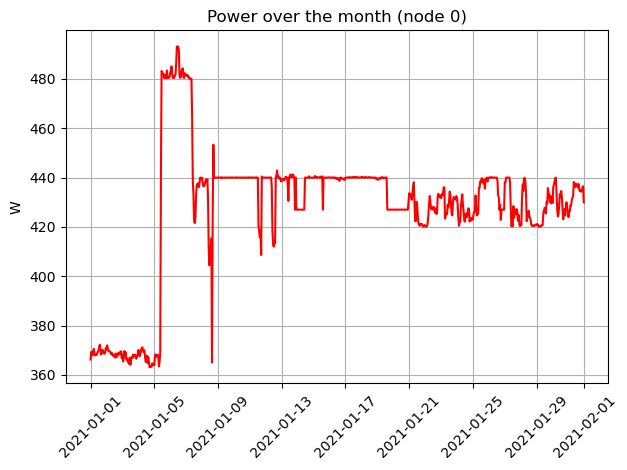

In [8]:
# To make future comparisons, we now plot the two initial sets of data 
plt.plot(dataset_P_node0, color='red')
plt.ylabel('W')
plt.title('Power over the month (node 0)')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

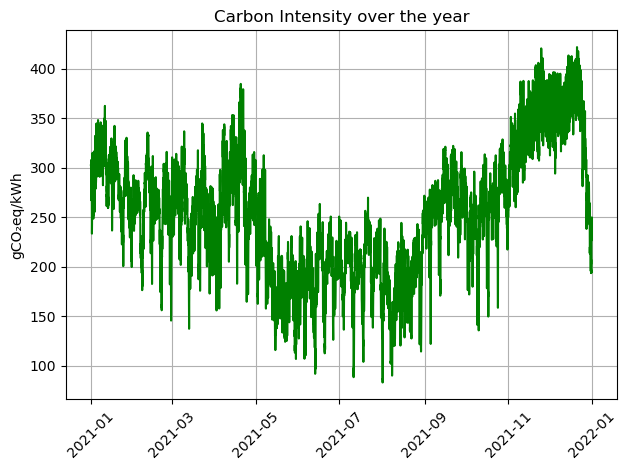

In [9]:
plt.plot(dataset_CI, color='green')
plt.ylabel('gCO₂eq/kWh')
plt.title('Carbon Intensity over the year')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

## Moving Average computation

In [10]:
# We'll use window sizes of 6, 12 and 24 hours, 1 week and also 1 month and compare the results
hours_per_week = 24 * 7
hours_per_month = 24 * 31

In [11]:
window_size = 6 # hours

# Moving Average computation for both datasets
dataset_P_MA6h = dataset_P_node0['power'].rolling(window=window_size).mean()
dataset_CI_MA6h = dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'].rolling(window=window_size).mean()

In [12]:
window_size = 12 # hours

# Moving Average computation for both datasets
dataset_P_MA12h = dataset_P_node0['power'].rolling(window=window_size).mean()
dataset_CI_MA12h = dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'].rolling(window=window_size).mean()

In [13]:
window_size = 24 # hours

# Moving Average computation for both datasets
dataset_P_MA24h = dataset_P_node0['power'].rolling(window=window_size).mean()
dataset_CI_MA24h = dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'].rolling(window=window_size).mean()

In [14]:
window_size = hours_per_week # hours

# Moving Average computation for both datasets
dataset_P_MA_week = dataset_P_node0['power'].rolling(window=window_size).mean()
dataset_CI_MA_week = dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'].rolling(window=window_size).mean()

In [15]:
window_size = hours_per_month # hours

# Moving Average computation for both datasets
dataset_P_MA_month = dataset_P_node0['power'].rolling(window=window_size).mean()
dataset_CI_MA_month = dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'].rolling(window=window_size).mean()

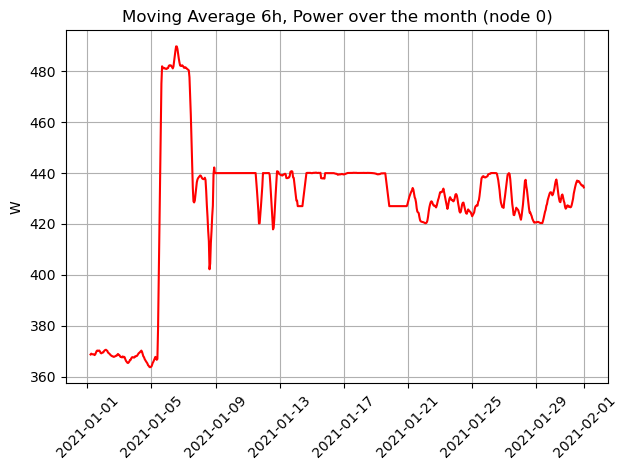

In [16]:
#POWER
plt.plot(dataset_P_MA6h, color='red')
plt.ylabel('W')
plt.title('Moving Average 6h, Power over the month (node 0)')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

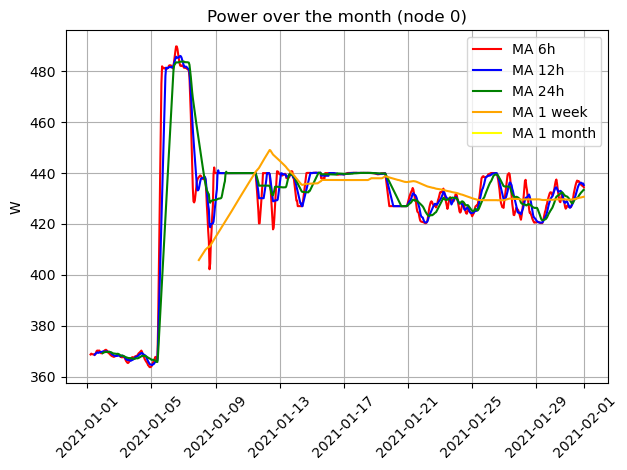

In [17]:
# POWER
plt.plot(dataset_P_MA6h, color='red', label='MA 6h')
plt.plot(dataset_P_MA12h, color='blue', label='MA 12h')
plt.plot(dataset_P_MA24h, color='green', label='MA 24h')
plt.plot(dataset_P_MA_week, color='orange', label='MA 1 week')
plt.plot(dataset_P_MA_month, color='yellow', label='MA 1 month')

plt.ylabel('W')
plt.grid(True)
plt.xticks(rotation=45) 
plt.title('Power over the month (node 0)')
plt.legend()

plt.tight_layout()
plt.show()

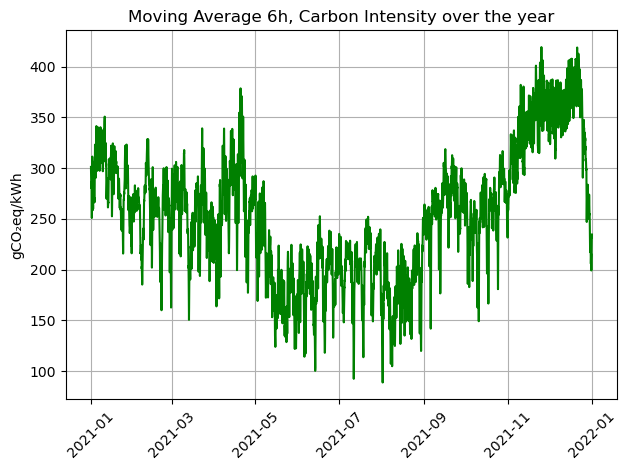

In [18]:
# CARBON INTENSITY
plt.plot(dataset_CI_MA6h, color='green')
plt.ylabel('gCO₂eq/kWh')
plt.title('Moving Average 6h, Carbon Intensity over the year')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

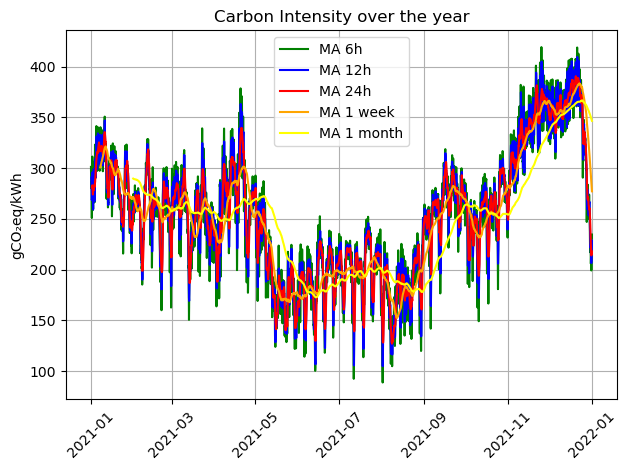

In [19]:
# CARBON INTENSITY
plt.plot(dataset_CI_MA6h, color='green', label='MA 6h')
plt.plot(dataset_CI_MA12h, color='blue', label='MA 12h')
plt.plot(dataset_CI_MA24h, color='red', label='MA 24h')
plt.plot(dataset_CI_MA_week, color='orange', label='MA 1 week')
plt.plot(dataset_CI_MA_month, color='yellow', label='MA 1 month')

plt.ylabel('gCO₂eq/kWh')
plt.grid(True)
plt.xticks(rotation=45) 
plt.title('Carbon Intensity over the year')
plt.legend()

plt.tight_layout()
plt.show()

### Considerations:

<span style="color:red;">Power:</span>

In power analysis of node 0, moving average gives us a trend which is similar to the one observed with the Cop we computed previously, but to make broader assumptions we probably need to work with a wider range of time. For the same reason it is very hard to highlight any seasonality.

<span style="color:red;">Carbon intensity:</span>

Here it is much more straightforward to see both the trend and the seasonality: in cold seasons the amount is higher, surely because of the weather and the usage of electrical power in general; also we see a higher intensity during work days.

## Seasonal-Trend Decomposition using LOESS (STL)

In [20]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

register_matplotlib_converters()
sns.set_style("darkgrid")

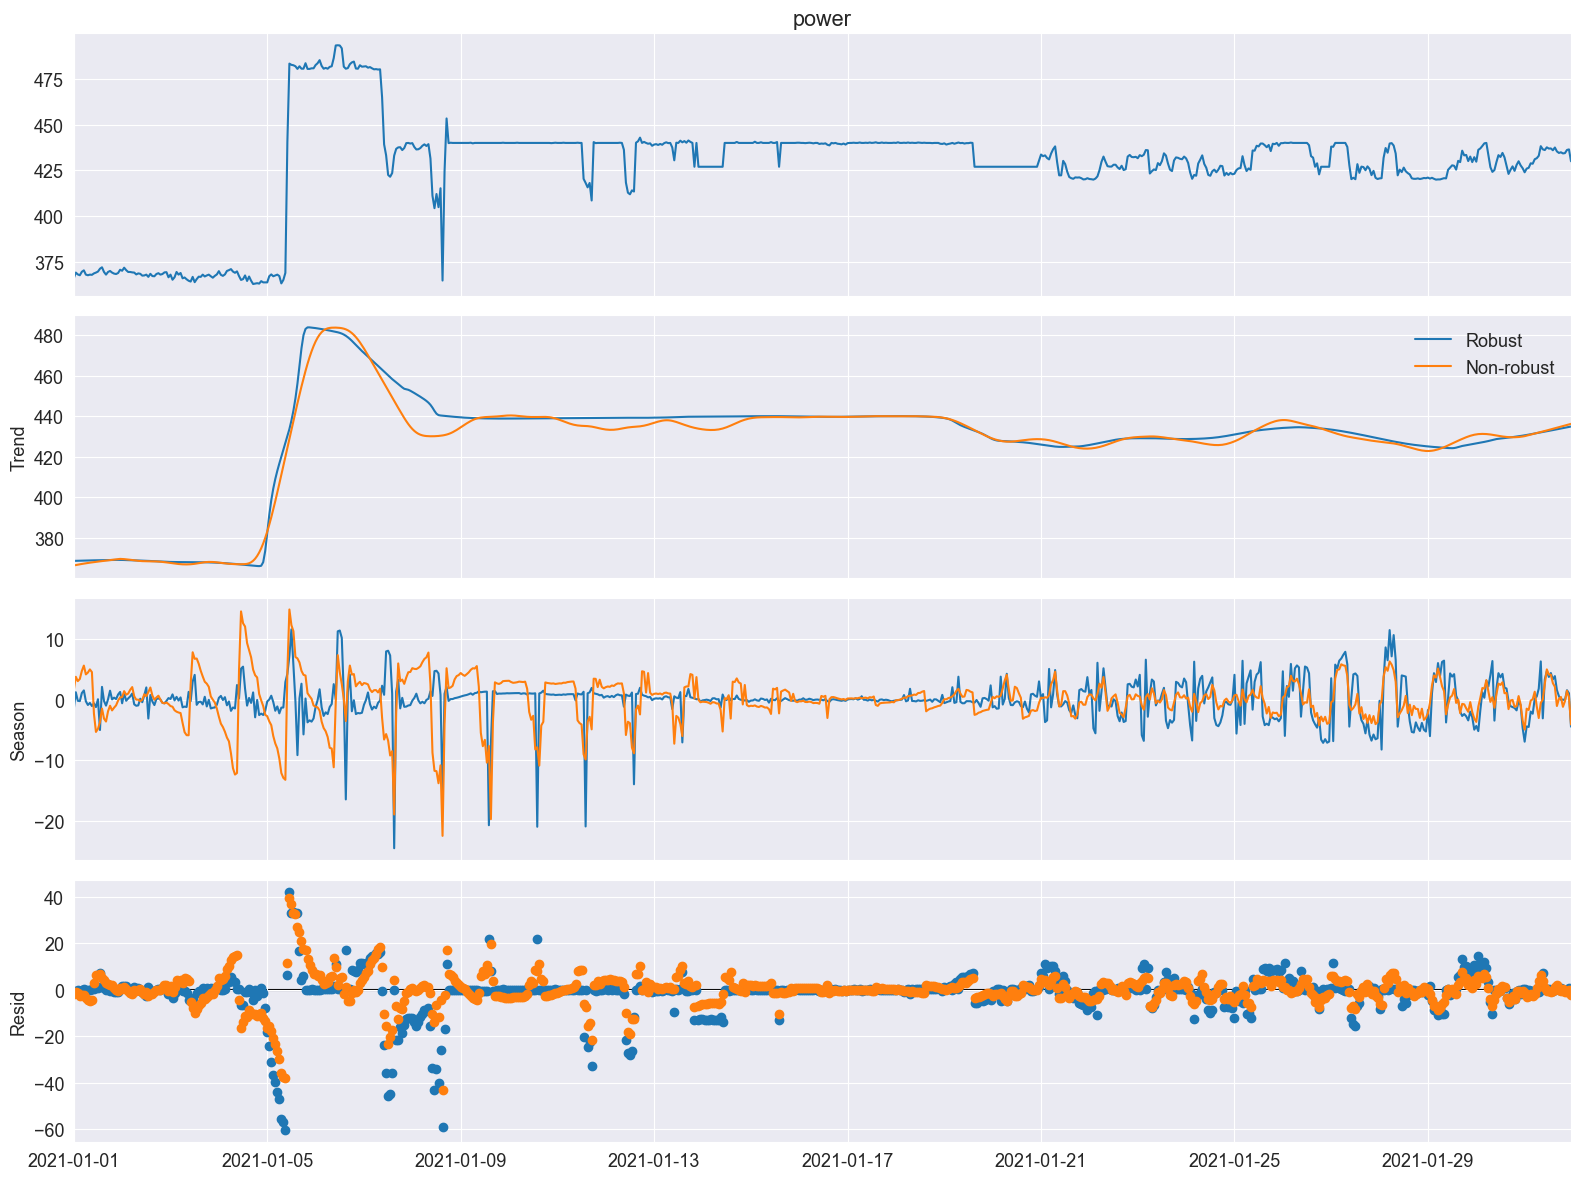

In [21]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(dataset_P_node0['power'], period=24, robust=True)  # the period is set to one day = 24h
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(dataset_P_node0['power'], period=24, robust=False).fit()  # the period is set to one day
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.tight_layout()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  func(*args, **kwargs)
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


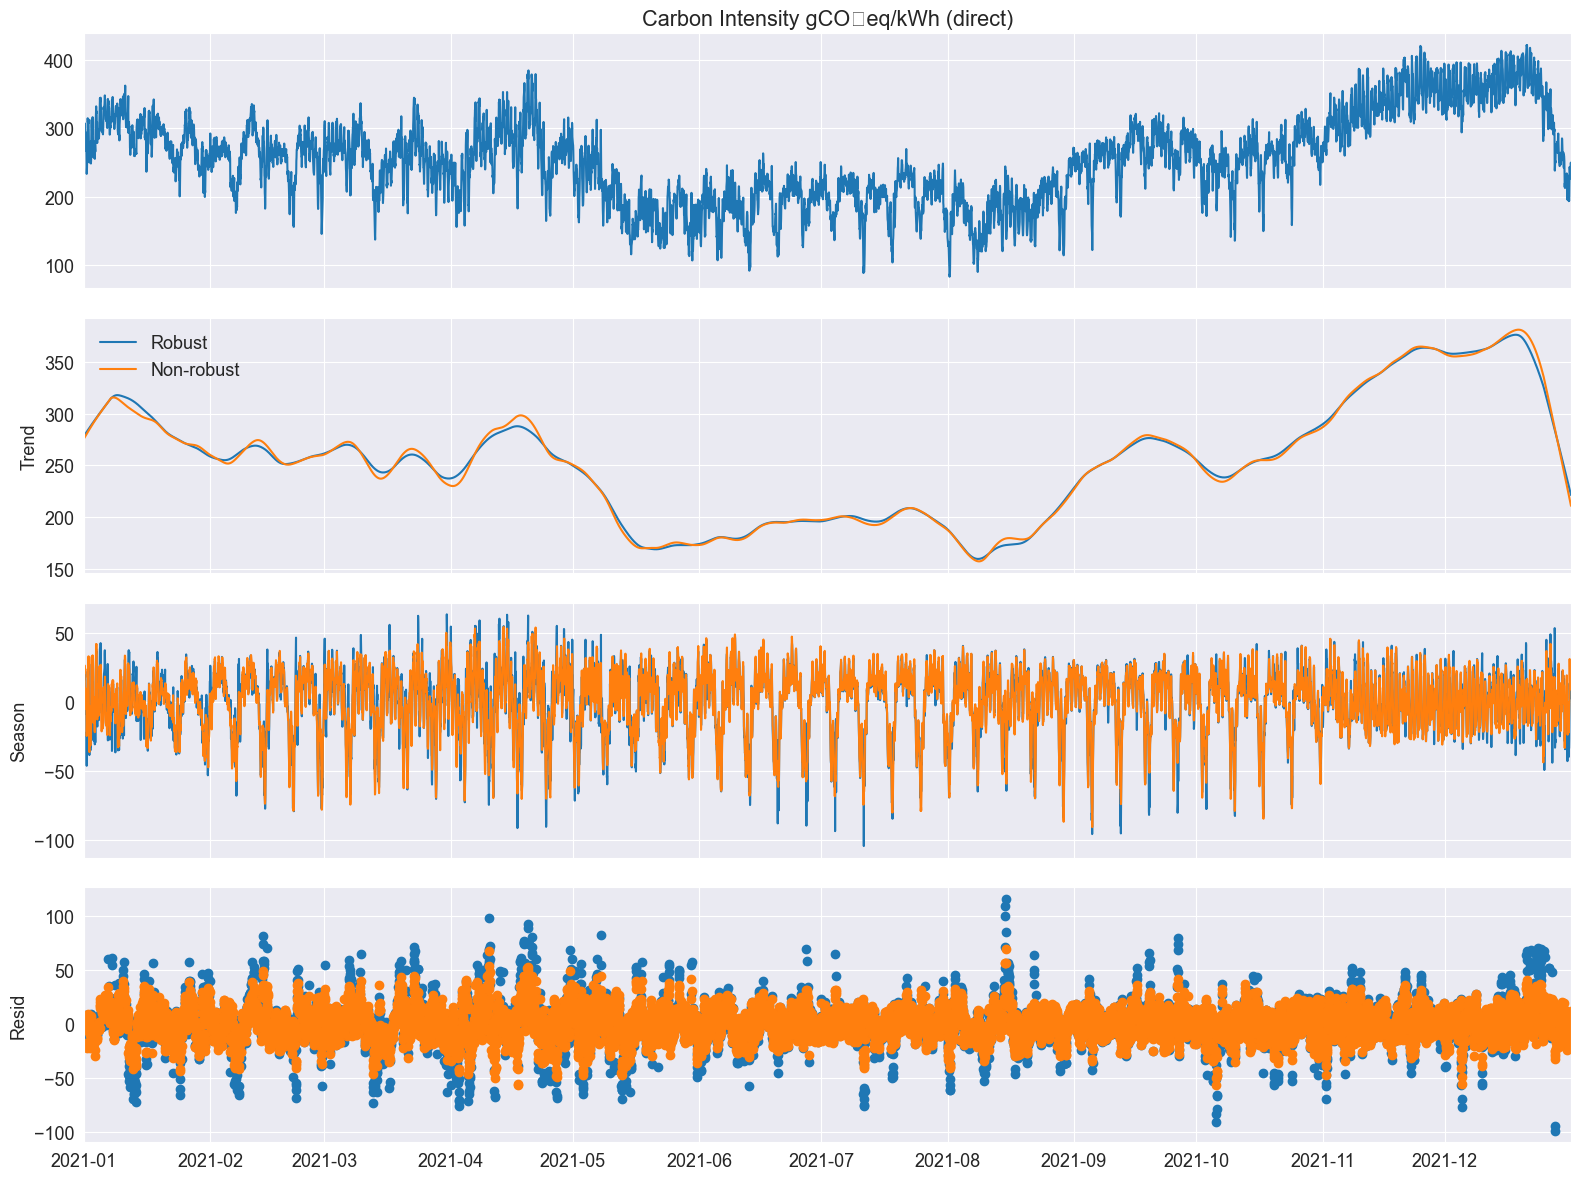

In [22]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'], period=hours_per_week+1, robust=True)  # the period is set to one week, which means 24h * 7days
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)'], period=hours_per_week+1, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

### Considerations:
To start it's better to generally describe what the different plots refer to: 

we can see the trend that follows the data we obtained, as well as its seasonality: the higher the amplitude of seasonality trend demonstrates increased changes in the original data. Along with this, there's a residual data graph which demonstrates the noise / discrepancies between trend and seasonality